In [1]:
import gymnasium as gym
cartpole = gym.make("InvertedPendulum-v4", render_mode="rgb_array")

In [2]:
s,_ = cartpole.reset()

In [3]:
print(s)

[ 0.0055234  -0.00533179  0.00840459 -0.00255076]


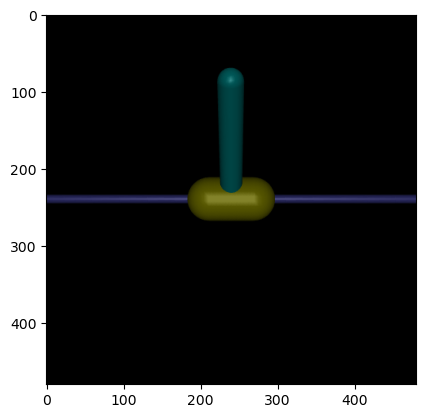

In [5]:
import matplotlib.pyplot as plt
plt.imshow(cartpole.render())

In [6]:
cartpole.single_observation_space

/home/emmanuel/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` for environment variables or `env.get_wrapper_attr('single_observation_space')` that will search the reminding wrappers.
  logger.warn(


AttributeError: 'InvertedPendulumEnv' object has no attribute 'single_observation_space'

In [26]:
bw = gym.make("BipedalWalker-v3", render_mode="human")

In [27]:
s,_ = bw.reset()
bw.render()
for _ in range(200):
    s,r,d,tr,_ = bw.step(bw.action_space.sample())
    bw.render()
    if d or tr:
        s,_ = bw.reset()
        bw.render()


In [28]:
bw.close()

In [32]:
bw = gym.make("BipedalWalker-v3", render_mode="rgb_array")
print(bw.observation_space)
print(bw.action_space)

Box([-3.1415927 -5.        -5.        -5.        -3.1415927 -5.
 -3.1415927 -5.        -0.        -3.1415927 -5.        -3.1415927
 -5.        -0.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.       ], [3.1415927 5.        5.        5.        3.1415927 5.        3.1415927
 5.        5.        3.1415927 5.        3.1415927 5.        5.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.       ], (24,), float32)
Box(-1.0, 1.0, (4,), float32)


# Deep deterministic policy gradients

## The deterministic policy gradient theorem

Let us, once again, restart from approximate value iteration (AVI) as a sequence of risk minimization problems.

<div class="alert alert-success">

**Approximate value iteration as a sequence of risk minimization problems**  
$$\pi_n \in \mathcal{G} Q_n,$$
$$L_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho}\left[ \left( Q(s,a;\theta) - G^{\pi_n}_1(s,a,Q_n) \right)^2 \right],$$
$$\theta_{n+1} \in \arg\min_{\theta} L_n(\theta),$$
$$Q_{n+1}(s,a) = Q(s,a;\theta_{n+1}).$$
</div>

For deterministic policies, we have
$$\pi \in \mathcal{G} Q, \Leftrightarrow \pi(s) \in \arg\max_{a \in A} \left[Q(s,a)\right], \forall s\in S.$$

Finding $\pi \in \mathcal{G}Q$ was relatively easy as long as there were few, discrete actions. But when actions are continuous, solving a $\max_a$ problem is a continuous optimization problem on which we have little knowledge.

Let us turn to what we called "weak optimality" in a previous chapter, that is, given a distribution $\rho_0(s)$ on starting states, the search for a policy that maximizes $J(\pi) = \mathbb{E}_{s\sim \rho_0} [V^\pi(s)]$. As indicated in previous chapters, finding a policy which maximizes this *average value across states* is not necessarily the same as finding a policy which *dominates any other policy in every state*. But in most practical cases, $J(\pi)$ is a very reasonable and interesting proxy for optimality.

Recall that $V^\pi(s) = Q^\pi(s,\pi(s))$. 
So, for a given function $Q$, instead of looking for $\pi(s) \in \arg\max_{a \in A} \left[Q(s,a)\right], \forall s\in S$, we can redefine *greediness* and look for 
$$\pi \in \arg\max_{a \in A} \mathbb{E}_{s\sim \rho_0} [Q(s,\pi(s))] = J_Q(\pi).$$
If $Q=Q^*$, then a maximizer of this quantity is a maximizer of $J(\pi)$.

Now if $\pi$ is a parameterized function $\pi_w$, then one can try to approximate $\pi_n \in \mathcal{G}Q_n$ by taking gradient steps on $J_{Q_n}(\pi_w)$. This is the key idea behind deterministic policy gradient algorithms.

It relies on the deterministic policy gradient theorem, introduced by Silver at al (2014)in the **[Deterministic Policy Gradient Algorithms](https://proceedings.mlr.press/v32/silver14.html)** paper.

Let us write $J(w) = J(\pi_w)$ for a parametric policy $\pi_w$.  
Write also $\rho^{\pi_w}(s) = \sum\limits_{t = 0}^\infty \gamma^t p(S_t=s|\rho_0,\pi_w)$ for all $s \in S$ the state occupancy measure of $\pi_w$ given $\rho_0$.

<div class="alert alert-success">

**Deterministic policy gradient theorem**  
Consider a deterministic policy $\pi_w: S\rightarrow A$ interacting with an MDP $S, A, p, r)$ with a starting state distribution $\rho_0$.  
We will drop the $w$ subscripts wherever unambiguous, to improve readability.    
If $p(s,a)$, $\nabla_a p(s'|s,a)$, $r(s,a)$, $\nabla_a r(s,a)$, $\rho_0(s)$, $\pi_w(s)$, and $\nabla_w\pi_w(s)$ all exist and are continuous in $(s,a,s')$, then 
$$\nabla_w J(w) = \mathbb{E}_{s\sim \rho^{\pi}} \left[ \nabla_a Q^{\pi}(s,a)|_{a=\pi(s)} \cdot \nabla_w \pi_w(s) \right].$$
</div>

Note that $\nabla_w \pi_w(s)$ is a Jacobian matrix where each column is the derivative of an action variable with respect to the parameters $w$.

Rewriting this theorem with partial derivatives, we have:
$$\nabla_w J(w) = \mathbb{E}_{s\sim \rho^{\pi}} \left[ \frac{\partial Q^{\pi}(s,a)}{\partial a}(s,\pi(s)) \cdot \frac{\partial \pi(s)}{\partial w}(s) \right].$$

This theorem looks like the chain rule applied to $J(\pi_w)$ but it's actually a bit more than that.

Let us write $J(w)=J(\pi_w)$ again.
\begin{align*}
J(w) &= \mathbb{E}_{s\sim \rho_0} [V^{\pi_w}(s)]\\
 &= \mathbb{E}_{s\sim \rho_0} [Q^{\pi_w}(s,\pi_w(s))]
\end{align*}

Let us take the gradient of this term with respect to $w$.
$$\nabla_w J(w) = \mathbb{E}_{s\sim \rho_0} \left[ \frac{\partial Q^{\pi_w}(s,\pi_w(s))}{\partial w} \right].$$

If we had had a fixed $Q$ instead of $Q^{\pi_w}$ in the expression above, we could have used the chain rule and we could have written:
$$\frac{\partial Q(s,\pi_w(s))}{\partial w}  = \frac{\partial Q(s,a)}{\partial a}|_{a=\pi_w(s)} \frac{\partial \pi_w(s)}{\partial w}(s).$$

But we don't have a fixed $Q$, and as soon as $w$ changes infinitesimally, $Q^{\pi_w}$ changes too, so this chain rule is not so straightforward.

The full proof of the deterministic policy gradient theorem is in the appendix of the aforementionned paper and we will not recall it here. In short, the derivation implies unfolding the sum over times steps of reward random variables in $Q^\pi$, which leads to the introduction of $\rho^\pi$.  

Instead, we will try to provide intuition as to why this gradient ascent direction makes sense in an AVI context.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

TODO: change names for action scale and action bias maybe?

In [ ]:
import torch
import torch.nn as nn

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, action_dim)
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

In [ ]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
config = 
rb = 

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

qf1 = QNetwork(state_dim,action_dim).to(device)
qf1_target = QNetwork(state_dim,action_dim).to(device)
qf1_target.load_state_dict(qf1.state_dict())

actor = Actor(state_dim,action_dim).to(device)
target_actor = Actor(state_dim,action_dim).to(device)
target_actor.load_state_dict(actor.state_dict())

q_optimizer = optim.Adam(list(qf1.parameters()), lr=config.learning_rate)
actor_optimizer = optim.Adam(list(actor.parameters()), lr=config.learning_rate)

# step (policy + noise), add to rb

# if done, print episode info

s = s2